# Introduction to Active Learning
This notebook outlines a strategy for active learning. Active learning is a strategy that targets situations in that data is abundant but labeling all of this data is too cost/time intensive. Active learning tackles this situation by training an initial model with a minimum amount of labeled data and then attempts to improve performance of this model to needed specifications by requesting a minimum amount of additionally labelled data from an "oracle". 

To ensure that these requests are indeed kept to a minimum, requests are commonly based on a informativeness or representativeness criterion. In this context, informativeness can be e.g. uncertainty. It is highly intuitive that learning from data points with previously high uncertainty is benificial. Deep learning models are trained in batch mode. It is not practical to add a single sample with previously high uncertainty to the training data and then retrain, both because retraining so frequently would be too time intensive and also because adding a single sample will not have a large impact on  a deep learning model. Adding a batch of samples to the training data solely based on uncertainty does frequently not increase increase performance as expected. Even though every of the new samples in itself might be highly informative for the model, low diversity within these new batch samples can significantly diminish the expected effect. On the other hand, chosing new samples solely based on representativeness frequently means that samples distant to the decision boundary are selected.

Naturally, a combination of the informativeness and representativeness approach may leverage the best of both worlds. This was for example demonstrated by Zhdanov ([Diverse mini-batch Active Learning](https://doi.org/10.48550/arXiv.1901.05954)).

In this notebook, we compare three request strategies on the MNIST dataset of handwritten digits. Namely, these strategies entail requesting new data points based on:
- random sampling (baseline)
- selection of data points with highest uncertainty
- preselection of data points based on uncertainty and then selecting the most representative data points within this preselection.


Before we perform this comparison, we will first establish a method of uncertainty estimation.

In [1]:
import shutil
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     GlobalMaxPool2D, Dense, Dropout, SpatialDropout2D) 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import warnings
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn.cluster import MiniBatchKMeans

tf.autograph.set_verbosity(3)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Predicting Uncertainty by Monte Carlo Dropout

In this section, we establish a way to quantify the uncertainty of deep learning models. There are multiple methods for uncertainty estimation, e.g. [*deep ensembles*](https://arxiv.org/pdf/1612.01474.pdf), Monte-Carlo dropout, or *evidence*-based techniques (see [here](https://arxiv.org/abs/1802.10501) or [here](https://arxiv.org/abs/1806.01768?context=cs)). In *deep ensembles* multiple networks are trained and differences in predicted probabilities amongst these networks are used to estimate uncertainty. Even though this idea is easy to implement, training multiple networks is time intensive. *Evidence*-based techniques on the other hand require only one "shot". However, they are more difficult to implement and train and switching between classifaction and regression problems requires significant adaption in implementation. Monte-Carlo dropout requires only one model to be trained and its implementation is straightforward both for classification and regression tasks.

For Monte-Carlo dropout, a dropout layer that is active both during training and inference is inserted into the network. By predicting each sample mutliple times with such a network, we effectively mimic a *deep ensemble* while only having to train a single model. See following reference to explore the theory of this idea further: 
- Gal & Ghahramani, [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://mlg.eng.cam.ac.uk/yarin/PDFs/NIPS_2015_deep_learning_uncertainty.pdf).

Now, we will implement a CNN network with Monte-Carlo dropout:

In [2]:
def get_model(input_shape, no_classes, dropout_for_uncertainty):
    inputs = Input(shape=input_shape)
    initializer = tf.keras.initializers.HeNormal()
    x = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(inputs)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer=initializer)(x)
    x = SpatialDropout2D(0.1)(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.4)(x, training=False) # only applied during training
    x = Dropout(dropout_for_uncertainty)(x, training=True) # also applied on inference 
    x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(no_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def predict_with_uncertainty(X, model, repeats=40):
    no_classes = model.layers[-1].output.shape[1]
    probs = np.zeros((repeats, X.shape[0], no_classes))
    for repeat in range(repeats):
        probs[repeat] = model.predict(X)

    probs_mean = np.mean(probs, axis=0)
    probs_std = np.std(probs, axis=0)

    pred_classes = np.argmax(probs_mean, axis=1)        
    pred_classes_probs = probs_mean[list(range(len(pred_classes))), pred_classes]
    pred_classes_probs_std = probs_std[list(range(len(pred_classes))), pred_classes]        
    return pred_classes, pred_classes_probs, pred_classes_probs_std

To establish a baseline, we will first train a network without Monte-Carlo dropout on 2500 images from the MNIST dataset. Then, we will train a second model with Monte-Carlo dropout. Side notes:
- the MNIST dataset is reduced to a total of 10000 images in this notebook to reduce computational cost.
- no rigorous attempts to maximize accuracy are made since this notebook is not about achieving the best accuracy

In [3]:
(X_all, y_all), (_, _) = tf.keras.datasets.mnist.load_data()
X_all = tf.reshape(X_all, (-1, 28, 28, 1)) / 255
X_all, y_all = np.take(X_all, list(range(10000)), axis=0), np.take(y_all, list(range(10000)), axis=0)


def create_initial_data_split(X, y, no_train_initial, no_validation):
    idx = sample(range(X.shape[0]), no_train_initial)
    X_train, y_train =  np.take(X, idx, axis=0), np.take(y, idx, axis=0)
    X, y = np.delete(X, idx, axis=0), np.delete(y, idx, axis=0)
    
    idx = sample(range(X.shape[0]), no_validation)
    X_validation, y_validation = np.take(X, idx, axis=0), np.take(y, idx, axis=0)
    X_holdout, y_holdout = np.delete(X, idx, axis=0), np.delete(y, idx, axis=0)
    return X_train, y_train, X_validation, y_validation, X_holdout, y_holdout


X_train, y_train, X_validation, y_validation, X_holdout, y_holdout = create_initial_data_split(X_all, y_all, 2500, 2500)

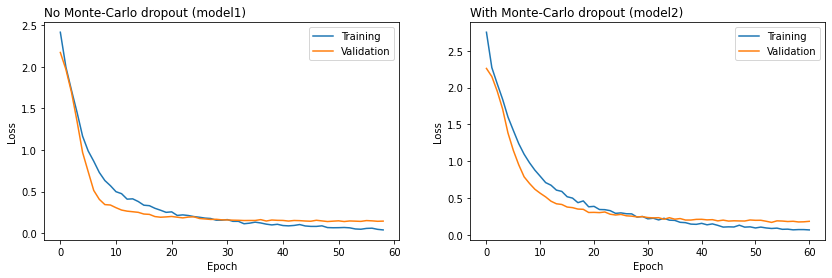

Accuracy for model1 (no Monte-Carlo dropout) on the validation data: 0.966
Accuracy for model2 (with Monte-Carlo dropout) on the validation data: 0.964


In [4]:
model1 = get_model((28,28,1), 10, 0.0)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True))
model2 = get_model((28,28,1), 10, 0.1)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True))

cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=7) 
cb2 = callbacks.ModelCheckpoint(".\\model1", monitor="val_loss", save_best_only=True)
cb3 = callbacks.ModelCheckpoint(".\\model2", monitor="val_loss", save_best_only=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history1 = model1.fit(X_train, y_train, epochs=100, batch_size=32,
                          validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1, cb2])
    model1 = tf.keras.models.load_model(".\\model1", compile=False)
    history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32,
                          validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1, cb3])
    model2 = tf.keras.models.load_model(".\\model2", compile=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(history1.history["loss"], label="Training")
ax1.plot(history1.history["val_loss"], label="Validation")
ax1.set_title("No Monte-Carlo dropout (model1)", loc="left")
ax2.plot(history2.history["loss"], label="Training")
ax2.plot(history2.history["val_loss"], label="Validation")
ax2.set_title("With Monte-Carlo dropout (model2)", loc="left")

for axi in [ax1, ax2]:
    axi.set_xlabel("Epoch")
    axi.set_ylabel("Loss")
    axi.legend()
plt.show()

pred_classes1, pred_probs1, _ = predict_with_uncertainty(X_holdout, model1, repeats=1)
pred_classes2, pred_probs2, pred_uncertainty2 = predict_with_uncertainty(X_holdout, model2)
scorer_accuracy = tf.keras.metrics.Accuracy()
accuracy_m1 = scorer_accuracy(y_holdout, pred_classes1)
scorer_accuracy.reset_state()
accuracy_m2 = scorer_accuracy(y_holdout, pred_classes2)
print(f"Accuracy for model1 (no Monte-Carlo dropout) on the validation data: {accuracy_m1:.3f}")
print(f"Accuracy for model2 (with Monte-Carlo dropout) on the validation data: {accuracy_m2:.3f}")

Interestingly enough, the Monte-Carlo dropout layer does not decrease accuracy (within the limits of significance). This can be mainly explained from the fact that this model is essential an ensemble. But more interestingly, we can see a well documented phenomen for the model without Monte-Carlo dropout: Even when this network makes wrong predictions, it does so with high confidence (high probability). In the right plot however, we can see that the uncertainty estimation from our model with Monte-Carlo dropout is significantly higher for wrong predictions compared to correct predictions:

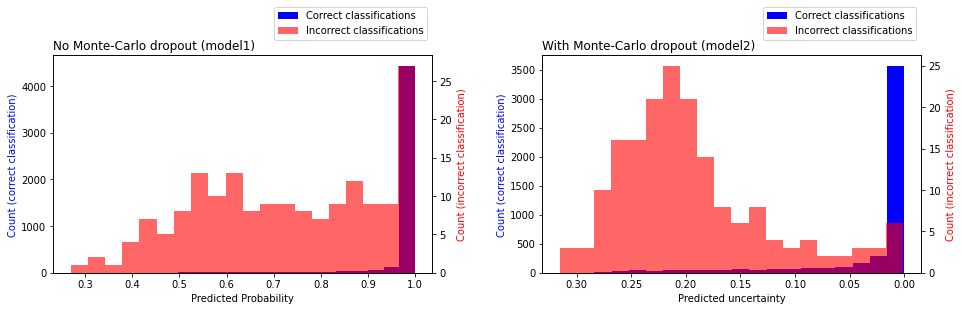

In [5]:
probs1_correct_classifications = pred_probs1[np.where(pred_classes1 == y_holdout)[0]]
probs1_incorrect_classifications = pred_probs1[np.where(pred_classes1 != y_holdout)[0]]

unc2_correct_classifications = pred_uncertainty2[np.where(pred_classes2 == y_holdout)[0]]
unc2_incorrect_classifications = pred_uncertainty2[np.where(pred_classes2 != y_holdout)[0]]

fig, (ax1_a, ax2_a) = plt.subplots(1, 2, figsize=(14, 5))
ax1_a.set_xlabel("Predicted Probability")
ax1_a.hist(probs1_correct_classifications, bins=20, alpha=1, color="blue", label="Correct classifications")
ax1_a.set_ylabel("Count (correct classification)", color="blue")
ax1_b = ax1_a.twinx() 
ax1_b.hist(probs1_incorrect_classifications, bins=20, alpha=0.6, color="red", label="Incorrect classifications")
ax1_b.set_ylabel("Count (incorrect classification)", color="red")
ax1_a.set_title("No Monte-Carlo dropout (model1)", loc="left")

ax2_a.set_xlabel("Predicted uncertainty")
ax2_a.hist(unc2_correct_classifications, bins=20, alpha=1, color="blue", label="Correct classifications")
ax2_a.set_ylabel("Count (correct classification)", color="blue")
ax2_a.invert_xaxis()
ax2_b = ax2_a.twinx() 
ax2_b.hist(unc2_incorrect_classifications, bins=20, alpha=0.6, color="red", label="Incorrect classifications")
ax2_b.set_ylabel("Count (incorrect classification)", color="red")
ax2_a.set_title("With Monte-Carlo dropout (model2)", loc="left")

lines, labels = [], []
for axi in [ax1_a, ax1_b]:
    axLine, axLabel = axi.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
ax1_a.legend(lines, labels, loc="lower right", bbox_to_anchor=(0, 1.05, 1, 0.2))
ax2_a.legend(lines, labels, loc="lower right", bbox_to_anchor=(0, 1.05, 1, 0.2))
plt.tight_layout(pad=3.0)
plt.show()

# Active Learning
In this section, the three request strategies are compared. To repeat, these strategies entail requesting new data points based on:
- random sampling (baseline)
- selection of data points with highest uncertainty
- preselection of data points based on uncertainty and then selecting the most representative data points within this preselection.

Due to the stochastic nature of deep learning such a comparison can only be meaningful if variance is assesed. Therefore, each strategy is repeated ten times. We start with an initial data set of 125 images and then have eight request stages were 25 images are added each time. For the approach that combines the informativeness or representativeness approach, beta (=5) * 25 images are preselected and then after *k*-means clustering (with *k* = 25), 25 images that are most close to the cluster centers are selected.

In [6]:
no_train_initial = 125
no_mini_batch_cycles = 6
mini_batch_size = 50
no_validation = 2000
no_of_repeats = 20
beta = 10

Now, let's look at our baseline were requests are based on random sampling:

In [7]:
accuracies_random_sampling = np.zeros((no_of_repeats, no_mini_batch_cycles))
for repeat in range(no_of_repeats):
    print(f"Repeat: {repeat+1}")
    X_train, y_train, X_validation, y_validation, X_holdout, y_holdout = create_initial_data_split(
        X_all, y_all, no_train_initial, no_validation)
    for batch_cycle in range(no_mini_batch_cycles):
        try:
            shutil.rmtree(".\\model3")
        except FileNotFoundError:
            None
        cb4 = callbacks.ModelCheckpoint(".\\model3", monitor="val_loss", save_best_only=True)

        # Model training
        model3 = get_model((28,28,1), 10, 0.1)
        model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                       loss=SparseCategoricalCrossentropy(from_logits=True))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            history3 = model3.fit(X_train, y_train, epochs=200, batch_size=32,
                                  validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1, cb4])
            model3 = tf.keras.models.load_model(".\\model3", compile=False)
            
        # Model evaluation on holdout data 
        pred_classes3, pred_probs3, pred_uncertainty3 = predict_with_uncertainty(X_holdout, model3)
        scorer_accuracy.reset_state()
        cur_accuracy = scorer_accuracy(y_holdout, pred_classes3)
        accuracies_random_sampling[repeat, batch_cycle] = cur_accuracy
        
        print(f"Cycle {str(batch_cycle+1).zfill(2)}: ({X_train.shape[0]}/{X_validation.shape[0]}/{X_holdout.shape[0]}) \
train/valid./houldout images. Accuracy (holdout): {cur_accuracy:.3f}. \
Mean uncertainty (holdout): {np.mean(pred_uncertainty3):.3f}")
        
        # Sampling new images that are added to the training data (random sampling)
        idx_to_draw = sample(range(X_holdout.shape[0]), mini_batch_size)
        X_train_new, y_train_new = np.take(X_holdout, idx_to_draw, axis=0), np.take(y_holdout, idx_to_draw, axis=0)
        X_train, y_train = np.concatenate((X_train, X_train_new), axis=0), np.concatenate((y_train, y_train_new), axis=0)
        X_holdout, y_holdout = np.delete(X_holdout, idx_to_draw, axis=0), np.delete(y_holdout, idx_to_draw, axis=0)

Repeat: 1
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.791. Mean uncertainty (holdout): 0.140
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.879. Mean uncertainty (holdout): 0.122
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (holdout): 0.916. Mean uncertainty (holdout): 0.097
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.932. Mean uncertainty (holdout): 0.073
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.923. Mean uncertainty (holdout): 0.070
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (holdout): 0.945. Mean uncertainty (holdout): 0.057
Repeat: 2
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.822. Mean uncertainty (holdout): 0.149
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.850. Mean uncertainty (holdout): 0.134
Cycle 03: (225/2000/7775) train/valid./hould

Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.909. Mean uncertainty (holdout): 0.085
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.927. Mean uncertainty (holdout): 0.064
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (holdout): 0.921. Mean uncertainty (holdout): 0.087
Repeat: 13
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.805. Mean uncertainty (holdout): 0.142
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.850. Mean uncertainty (holdout): 0.127
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (holdout): 0.830. Mean uncertainty (holdout): 0.134
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.911. Mean uncertainty (holdout): 0.081
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.918. Mean uncertainty (holdout): 0.092
Cycle 06: (375/2000/7625) train/valid./houldout image

Now, let's look at the *informativeness only* approach:

In [8]:
accuracies_uncertainty_sampling = np.zeros((no_of_repeats, no_mini_batch_cycles))
for repeat in range(no_of_repeats):
    print(f"Repeat: {repeat+1}")
    X_train, y_train, X_validation, y_validation, X_holdout, y_holdout = create_initial_data_split(
        X_all, y_all, no_train_initial, no_validation)
    for batch_cycle in range(no_mini_batch_cycles):
        try:
            shutil.rmtree(".\\model4")
        except FileNotFoundError:
            None
        cb5 = callbacks.ModelCheckpoint(".\\model4", monitor="val_loss", save_best_only=True)
        # Model training
        model4 = get_model((28,28,1), 10, 0.1)
        model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                       loss=SparseCategoricalCrossentropy(from_logits=True))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            history4 = model4.fit(X_train, y_train, epochs=200, batch_size=32,
                                  validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1, cb5])
            model4 = tf.keras.models.load_model(".\\model4", compile=False)
            
        # Model evaluation on holdout data 
        pred_classes4, pred_probs4, pred_uncertainty4 = predict_with_uncertainty(X_holdout, model4)
        scorer_accuracy.reset_state()
        cur_accuracy = scorer_accuracy(y_holdout, pred_classes4)
        accuracies_uncertainty_sampling[repeat, batch_cycle] = cur_accuracy
        
        print(f"Cycle {str(batch_cycle+1).zfill(2)}: ({X_train.shape[0]}/{X_validation.shape[0]}/{X_holdout.shape[0]}) \
train/valid./houldout images. Accuracy (holdout): {cur_accuracy:.3f}. \
Mean uncertainty (holdout): {np.mean(pred_uncertainty4):.3f}")
        
        # Sampling new images that are added to the training data (random sampling)
        idx_to_draw = np.argsort(pred_uncertainty4)[-mini_batch_size:]
        X_train_new, y_train_new = np.take(X_holdout, idx_to_draw, axis=0), np.take(y_holdout, idx_to_draw, axis=0)
        X_train, y_train = np.concatenate((X_train, X_train_new), axis=0), np.concatenate((y_train, y_train_new), axis=0)
        X_holdout, y_holdout = np.delete(X_holdout, idx_to_draw, axis=0), np.delete(y_holdout, idx_to_draw, axis=0)

# print(accuracies_uncertainty_sampling)

Repeat: 1
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.857. Mean uncertainty (holdout): 0.136
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.898. Mean uncertainty (holdout): 0.103
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (holdout): 0.911. Mean uncertainty (holdout): 0.104
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.934. Mean uncertainty (holdout): 0.075
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.940. Mean uncertainty (holdout): 0.062
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (holdout): 0.951. Mean uncertainty (holdout): 0.056
Repeat: 2
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.796. Mean uncertainty (holdout): 0.138
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.876. Mean uncertainty (holdout): 0.103
Cycle 03: (225/2000/7775) train/valid./hould

Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.914. Mean uncertainty (holdout): 0.075
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.924. Mean uncertainty (holdout): 0.090
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (holdout): 0.943. Mean uncertainty (holdout): 0.055
Repeat: 13
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (holdout): 0.846. Mean uncertainty (holdout): 0.135
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (holdout): 0.882. Mean uncertainty (holdout): 0.115
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (holdout): 0.914. Mean uncertainty (holdout): 0.090
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (holdout): 0.928. Mean uncertainty (holdout): 0.083
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (holdout): 0.937. Mean uncertainty (holdout): 0.058
Cycle 06: (375/2000/7625) train/valid./houldout image

And finally, the combinations of the informativeness and representativeness approach. Please note that *k*-means clustering images as performed here, may not be the best way to go as spatial features are lost by this. It might be more meaningful to train a convolutional autoencoder and then perform *k*-means clustering on the latent variables. However, this is not done here in order to avoid too much complexity.

In [9]:
accuracies_mixed_sampling = np.zeros((no_of_repeats, no_mini_batch_cycles))
for repeat in range(no_of_repeats):
    print(f"Repeat: {repeat+1}")
    X_train, y_train, X_validation, y_validation, X_holdout, y_holdout = create_initial_data_split(
        X_all, y_all, no_train_initial, no_validation)
    for batch_cycle in range(no_mini_batch_cycles):
        try:
            shutil.rmtree(".\\model5")
        except FileNotFoundError:
            None
        cb6 = callbacks.ModelCheckpoint(".\\model5", monitor="val_loss", save_best_only=True)

        # Model training
        model5 = get_model((28,28,1), 10, 0.1)
        model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                       loss=SparseCategoricalCrossentropy(from_logits=True))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            history5 = model5.fit(X_train, y_train, epochs=200, batch_size=32,
                                  validation_data=(X_validation, y_validation), verbose=0, callbacks=[cb1, cb6])
            model5 = tf.keras.models.load_model(".\\model5", compile=False)
            
        # Model evaluation on holdout data 
        pred_classes5, pred_probs5, pred_uncertainty5 = predict_with_uncertainty(X_validation, model5)
        scorer_accuracy.reset_state()
        cur_accuracy = scorer_accuracy(y_validation, pred_classes5)
        accuracies_mixed_sampling[repeat, batch_cycle] = cur_accuracy
        
        print(f"Cycle {str(batch_cycle+1).zfill(2)}: ({X_train.shape[0]}/{X_validation.shape[0]}/{X_holdout.shape[0]}) \
train/valid./houldout images. Accuracy (valid.): {cur_accuracy:.3f}. \
Mean uncertainty (holdout): {np.mean(pred_uncertainty5):.3f}")
        
        # Sampling new images that are added to the training data (random sampling)
        idx_to_draw_candidates = np.argsort(pred_uncertainty5)[-mini_batch_size*beta:]
        X_train_new_candidates = np.take(X_holdout, idx_to_draw_candidates, axis=0).reshape(-1, (28*28))
        X_train_new_candidates = X_train_new_candidates.reshape(-1, (28*28))
        
        mbk = MiniBatchKMeans(init="k-means++", n_clusters=mini_batch_size, n_init=10, max_no_improvement=10)
        dist_to_cluster_centers = mbk.fit_transform(X_train_new_candidates)
        
        idx_to_draw = np.take(idx_to_draw_candidates, np.argmin(dist_to_cluster_centers, axis=0))
        X_train_new, y_train_new = np.take(X_holdout, idx_to_draw, axis=0), np.take(y_holdout, idx_to_draw, axis=0)
        X_train, y_train = np.concatenate((X_train, X_train_new), axis=0), np.concatenate((y_train, y_train_new), axis=0)
        X_holdout, y_holdout = np.delete(X_holdout, idx_to_draw, axis=0), np.delete(y_holdout, idx_to_draw, axis=0)

Repeat: 1
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (valid.): 0.811. Mean uncertainty (holdout): 0.145
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (valid.): 0.879. Mean uncertainty (holdout): 0.120
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (valid.): 0.902. Mean uncertainty (holdout): 0.097
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (valid.): 0.909. Mean uncertainty (holdout): 0.083
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (valid.): 0.911. Mean uncertainty (holdout): 0.094
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (valid.): 0.929. Mean uncertainty (holdout): 0.075
Repeat: 2
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (valid.): 0.846. Mean uncertainty (holdout): 0.123
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (valid.): 0.869. Mean uncertainty (holdout): 0.112
Cycle 03: (225/2000/7775) train/valid./houldout imag

Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (valid.): 0.928. Mean uncertainty (holdout): 0.070
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (valid.): 0.937. Mean uncertainty (holdout): 0.067
Repeat: 13
Cycle 01: (125/2000/7875) train/valid./houldout images. Accuracy (valid.): 0.835. Mean uncertainty (holdout): 0.147
Cycle 02: (175/2000/7825) train/valid./houldout images. Accuracy (valid.): 0.878. Mean uncertainty (holdout): 0.122
Cycle 03: (225/2000/7775) train/valid./houldout images. Accuracy (valid.): 0.897. Mean uncertainty (holdout): 0.114
Cycle 04: (275/2000/7725) train/valid./houldout images. Accuracy (valid.): 0.896. Mean uncertainty (holdout): 0.101
Cycle 05: (325/2000/7675) train/valid./houldout images. Accuracy (valid.): 0.924. Mean uncertainty (holdout): 0.068
Cycle 06: (375/2000/7625) train/valid./houldout images. Accuracy (valid.): 0.941. Mean uncertainty (holdout): 0.079
Repeat: 14
Cycle 01: (125/2000/7875) train/valid./houldout im

Finally, let's visualize the averaged outcomes (the bands represent one standard deviation):

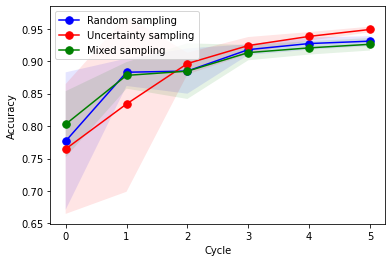

In [10]:
mean1 = np.mean(accuracies_random_sampling, axis=0)
std1 = np.std(accuracies_random_sampling, axis=0)
mean2 = np.mean(accuracies_uncertainty_sampling, axis=0)
std2 = np.std(accuracies_uncertainty_sampling, axis=0)
mean3 = np.mean(accuracies_mixed_sampling, axis=0)
std3 = np.std(accuracies_mixed_sampling, axis=0)

fig, ax = plt.subplots()
ax.plot(range(no_mini_batch_cycles), mean1, color="blue", marker=".", markersize=15, label="Random sampling")
ax.fill_between(range(no_mini_batch_cycles), mean1+std1, mean1-std1, facecolor="blue", alpha=0.1)
ax.plot(range(no_mini_batch_cycles), mean2, color="red", marker=".", markersize=15, label="Uncertainty sampling")
ax.fill_between(range(no_mini_batch_cycles), mean2+std2, mean2-std2, facecolor="red", alpha=0.1)
ax.plot(range(no_mini_batch_cycles), mean3, color="green", marker=".", markersize=15, label="Mixed sampling")
ax.fill_between(range(no_mini_batch_cycles), mean3+std3, mean3-std3, facecolor="green", alpha=0.1)
ax.set_xlabel("Cycle")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

It is apparent that variance is quite large in the initial cycles. This prevents us from drawing any conclusion of statistical significant there.

In the later cycles (4 & 5), variance is smaller and the uncertainty sampling strategy is outperforming random and mixed sampling. However, this is just one dataset and the improvement of the uncertainty sampling is rather small. So, this notebook can certainly not back any general statement about the effectivness of active learning or which active learning strategy is most efficient. It can be assumed that the relative easyness of the MNIST dataset prevents active learning from making a more significant impact.

Additionally, this notebook does not answer two major question that may make active learning even more relevant in many real world scenarios: 
- How can active learning deal with imbalanced data?
- How should the initial dataset be selected?

To get an idea on these matters, please see following papers:
- Aggarwal, Popescu, Hudelot: [Minority Class Oriented Active Learning for Imbalanced Datasets](https://doi.org/10.48550/arXiv.2202.00390). **2022**
- Barata, Leite, Pacheco, Sampaio, Ascensão, Bizarro: [Active learning for imbalanced data under cold start](https://doi.org/10.48550/arXiv.2107.07724). **2021**